<a href="https://colab.research.google.com/github/jisuseo/forecast_kimsasia/blob/main/forecast_kimsasia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [4]:
dataset_pur = pd.read_csv("/content/drive/MyDrive/#IT/forecast_kimsasia/data/20.10.2022-03.12.2024_purchase.csv", encoding = 'latin-1',  sep=';', skipinitialspace=True)
dataset_dem = pd.read_csv('/content/drive/MyDrive/#IT/forecast_kimsasia/data/20.10.2022-03.12.2024_demand.csv', encoding='latin-1', sep=';', skipinitialspace=True)


<ipython-input-4-1664d4b6aff1>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_dem = pd.read_csv('/content/drive/MyDrive/#IT/forecast_kimsasia/data/20.10.2022-03.12.2024_demand.csv', encoding='latin-1', sep=';', skipinitialspace=True)


In [5]:
dataset_dem['BDaAU'] = pd.to_datetime(dataset_dem['BDaAU'], format='%d.%m.%Y', errors='coerce')
dataset_dem = dataset_dem.dropna(subset=['BDaAU', 'Menge'])

In [6]:
# 랜덤 포레스트 기반 예측

dataset_dem['BDaAU_ordinal'] = dataset_dem['BDaAU'].map(pd.Timestamp.toordinal)
X = dataset_dem[['BDaAU_ordinal']]
y = dataset_dem['Menge']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RandomForest MSE: {mse}')

RandomForest MSE: 8409.193945307581


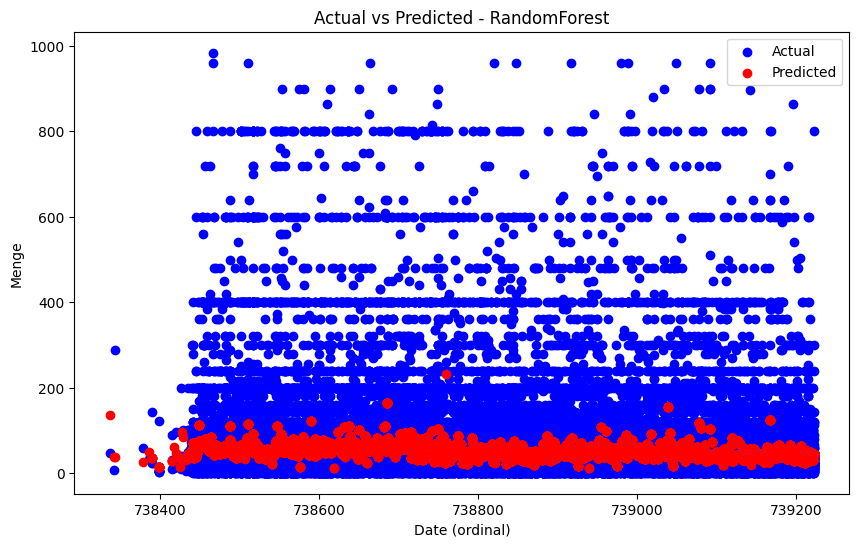

In [7]:
# 실제 vs 예측 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_test['BDaAU_ordinal'], y_test, label='Actual', color='blue')
plt.scatter(X_test['BDaAU_ordinal'], y_pred, label='Predicted', color='red')
plt.xlabel('Date (ordinal)')
plt.ylabel('Menge')
plt.legend()
plt.title('Actual vs Predicted - RandomForest')
plt.show()

In [8]:
# Prophet 기반 시계열 예측
prophet_data = dataset_dem[['BDaAU', 'Menge']].rename(columns={'BDaAU': 'ds', 'Menge': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tt33aht/yged8o_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tt33aht/fjdixvlw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99538', 'data', 'file=/tmp/tmp9tt33aht/yged8o_n.json', 'init=/tmp/tmp9tt33aht/fjdixvlw.json', 'output', 'file=/tmp/tmp9tt33aht/prophet_modelge4r4zjf/prophet_model-20250525143519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:35:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)


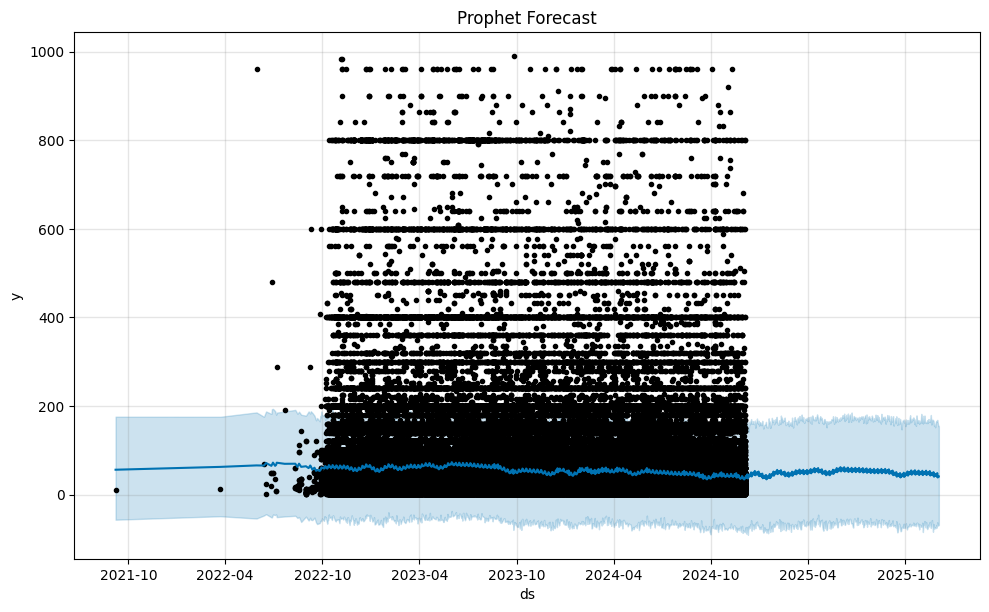

In [10]:
# 예측 시각화
fig1 = prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

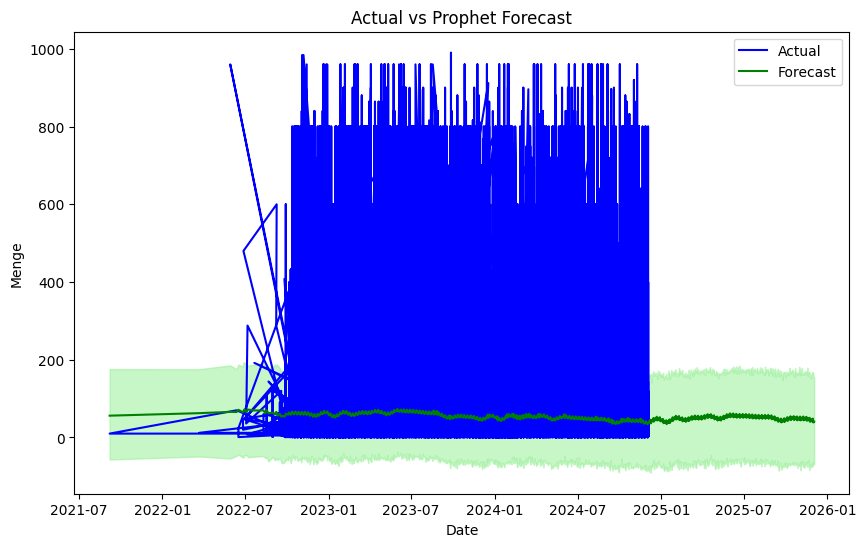

In [11]:
# 실제 데이터와 Prophet 예측 비교
plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightgreen', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Menge')
plt.title('Actual vs Prophet Forecast')
plt.legend()
plt.show()